In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta


# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [40]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\AdamKarner\AppData\Local\Temp\ipykernel_7444\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [42]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [43]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)


('2017-08-23',)


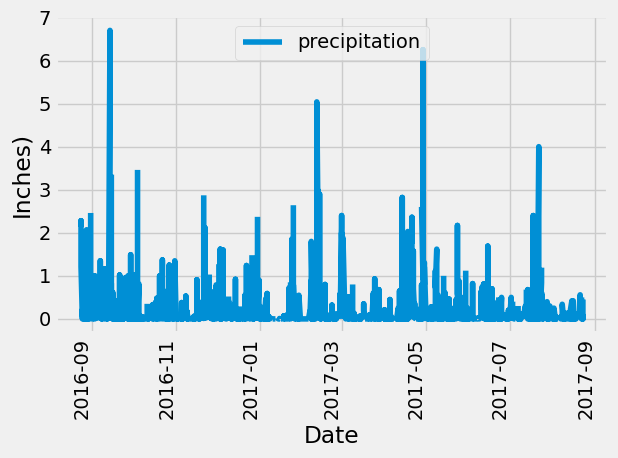

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_scores, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])  # Convert the date to datetime format
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches)')
plt.legend(loc='upper center')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe().to_frame()
summary_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).distinct().count()
total_stations

9

In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)
# List the stations and their counts in descending order.
for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [49]:
most_active_station = active_stations[0][0]
print(f"The station id that has the greatest number of observations is {most_active_station}")

The station id that has the greatest number of observations is USC00519281


In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = (
    session.query(
        func.min(measurement.tobs),  # Minimum temperature
        func.max(measurement.tobs),  # Maximum temperature
        func.avg(measurement.tobs)   # Average temperature
    )
    .filter(measurement.station == most_active_station)  # Filter by the most active station
    .all()
)
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


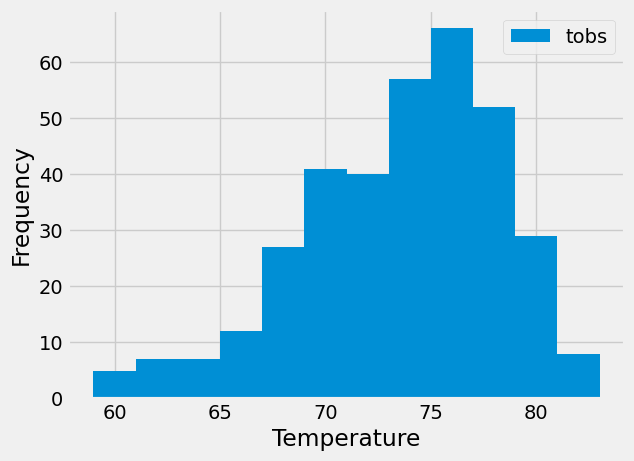

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_station)
    .filter(measurement.date >= one_year_ago)
    .all()
)
temperature_list = [temp[0] for temp in temperature_data]

plt.hist(temperature_list, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close Session

In [52]:
# Close Session
session.close()